# Tidy3D FDTD accuracy benchmark

Tidy3D offers a lightning-fast FDTD solver capable of completing simulations in a fraction of the time required by traditional FDTD solvers, reducing runtimes from hours or days to mere minutes. This is achieved through cutting-edge integration between our hardware and state-of-the-art numerical methods, which involves no approximations. Therefore, this enhanced speed does not compromise accuracy, as reliable results remain paramount to the utility of any simulation tool.

In order to investigate Tidy3D speed advantage and confirm its robustness, we will compare the results of a MMI power divider, available in our [application library](https://tidy3d.simulation.cloud/workbench?taskId=pa-5e58d0d7-c3dc-446c-9309-fab8b94da423), with those from the open-source software Meep.

In [1]:
import tidy3d as td
from tidy3d import web
import numpy as np
import matplotlib.pyplot as plt

## FDTD Simulation

The model is based on our web GUI [example](https://tidy3d.simulation.cloud/workbench?taskId=pa-5e58d0d7-c3dc-446c-9309-fab8b94da423). Below is the code exported directly from the GUI with minor modifications, including added comments and changes to variable names for improved readability:

In [2]:
# defining parameters
si_index = 3.48
sio2_index = 1.46
central_wavelength = 1.55
waveguide_width = 0.5
waveguide_thickness = 0.22
waveguide_length = 2
mmi_width = 3.6
mmi_length = 11.5
output_separation = 0.6
taper_width = 1.2
taper_length = 20.05
SiO2_medium = td.Medium(
    name="SiO2",
    permittivity=2.1316,
)

# operating frequency
freq0 = 193.414e12
fwidth = 6.24568e12

freqs = np.linspace(freq0 - fwidth, freq0 + fwidth, 50)

# mode source
Mode_source = td.ModeSource(
    name="Mode source",
    num_freqs=10,
    center=[-mmi_length / 2 - taper_length - waveguide_length / 2, 0, 0],
    size=[0, 3 * waveguide_width, 4 * waveguide_thickness],
    source_time=td.GaussianPulse(
        freq0=193414489032258.06,
        fwidth=6245676208333.328,
    ),
    direction="+",
    mode_spec=td.ModeSpec(
        target_neff=3.48,
    ),
)

# defining monitors for calculating transmittance and field visualization

Flux_monitor = td.FluxMonitor(
    name="Flux monitor",
    center=[
        mmi_length / 2 + taper_length + waveguide_length / 2,
        (output_separation + taper_width) / 2,
        0,
    ],
    size=[0, 3 * waveguide_width, 4 * waveguide_thickness],
    freqs=freqs,
    normal_dir="+",
)

Flux_monitorRef = td.FluxMonitor(
    name="Ref monitor",
    center=(Mode_source.center[0] + 0.5, Mode_source.center[1], Mode_source.center[2]),
    size=Mode_source.size,
    freqs=freqs,
    normal_dir="+",
)


Mode_monitor = td.ModeMonitor(
    name="Mode monitor",
    center=[
        mmi_length / 2 + taper_length + waveguide_length / 2,
        (output_separation + taper_width) / 2,
        0,
    ],
    size=[0, 3 * waveguide_width, 4 * waveguide_thickness],
    freqs=freqs,
    mode_spec=td.ModeSpec(
        num_modes=3,
        target_neff=3.48,
    ),
)

Field_monitor = td.FieldMonitor(
    name="Field monitor", size=[td.inf, td.inf, 0], freqs=[freq0], colocate=False
)

# defining mediums
Si_medium = td.Medium(
    name="Si",
    permittivity=12.1104,
)

# defining structures
MMI_section = td.Structure(
    name="MMI section",
    geometry=td.Box(size=[mmi_length, mmi_width, waveguide_thickness]),
    medium=Si_medium,
)

Input_taper = td.Structure(
    name="Input taper",
    geometry=td.PolySlab(
        slab_bounds=[-waveguide_thickness / 2, waveguide_thickness / 2],
        vertices=[
            [-mmi_length / 2 - taper_length, waveguide_width / 2],
            [-mmi_length / 2, taper_width / 2],
            [-mmi_length / 2, -taper_width / 2],
            [-mmi_length / 2 - taper_length, -waveguide_width / 2],
        ],
    ),
    medium=Si_medium,
)

Output_taper__top_ = td.Structure(
    name="Output taper (top)",
    geometry=td.PolySlab(
        slab_bounds=[-0.11, 0.11],
        vertices=[
            [mmi_length / 2, output_separation / 2],
            [mmi_length / 2, output_separation / 2 + taper_width],
            [
                mmi_length / 2 + taper_length,
                (output_separation + waveguide_width + taper_width) / 2,
            ],
            [
                mmi_length / 2 + taper_length,
                (output_separation - waveguide_width + taper_width) / 2,
            ],
        ],
    ),
    medium=Si_medium,
)

Output_taper__bottom_ = td.Structure(
    name="Output taper (bottom)",
    geometry=td.PolySlab(
        slab_bounds=[-0.11, 0.11],
        vertices=[
            [mmi_length / 2, -output_separation / 2],
            [mmi_length / 2, -output_separation / 2 - taper_width],
            [
                mmi_length / 2 + taper_length,
                -(output_separation + waveguide_width + taper_width) / 2,
            ],
            [
                mmi_length / 2 + taper_length,
                -(output_separation - waveguide_width + taper_width) / 2,
            ],
        ],
    ),
    medium=Si_medium,
)

Input_straight_waveguide = td.Structure(
    name="Input straight waveguide",
    geometry=td.Box(center=[-32.9, 0, 0], size=[14.2, 0.5, 0.22]),
    medium=Si_medium,
)

Output_straight_waveguide__top_ = td.Structure(
    name="Output straight waveguide (top)",
    geometry=td.Box(center=[32.9, 0.9, 0], size=[14.2, 0.5, 0.22]),
    medium=Si_medium,
)

Output_straight_waveguide__bottom_ = td.Structure(
    name="Output straight waveguide (bottom)",
    geometry=td.Box(center=[32.9, -0.9, 0], size=[14.2, 0.5, 0.22]),
    medium=Si_medium,
)

grid_spec = td.GridSpec.auto(min_steps_per_wvl=11)

sim_base = td.Simulation(
    size=[55.6, 6.925, 2.1],
    symmetry=[0, -1, 0],
    run_time=3e-12,
    grid_spec=grid_spec,
    medium=SiO2_medium,
    sources=[Mode_source],
    monitors=[Flux_monitor, Mode_monitor, Field_monitor, Flux_monitorRef],
    structures=[
        MMI_section,
        Input_taper,
        Output_taper__top_,
        Output_taper__bottom_,
        Input_straight_waveguide,
        Output_straight_waveguide__top_,
        Output_straight_waveguide__bottom_,
    ],
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.pml()
    ),
)

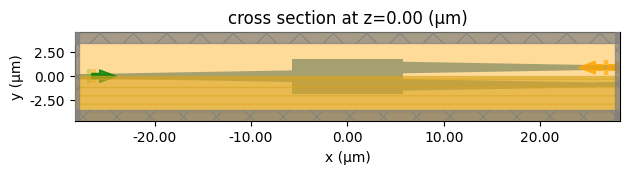

In [3]:
# plotting the simulation
sim_base.plot(z=0)
plt.show()

The Meep simulation was built to be equivalent to the Tidy3D one. The geometry was imported from the GDS file generated by the Tidy3D model, and the source and output monitor were positioned exactly as they are in Tidy3D. Since Meep sources are not normalized like those in Tidy3D, an additional monitor was placed immediately after the source in the Meep simulation to normalize the output. A schematic of the Meep model is shown in the figure below, where the red line represents the mode source, the blue lines represent the monitors, and the green area indicates the PML.

<img src="img/MeepMMIBenchmark.png" width="600" alt="Schematic of the experiment">

The Meep resolution was set to 30 steps per $\mu\text{m}$, which corresponds to approximately 13 steps per wavelength in silicon. Therefore, we will create and run a new Tidy3D simulation object with this grid specification.

In [4]:
grid_spec = td.GridSpec.auto(min_steps_per_wvl=13)
sim = sim_base.updated_copy(grid_spec=grid_spec)
sim_data = web.run(simulation=sim, task_name="MMI")

15:08:01 -03 Created task 'MMI' with task_id                                    
             'fdve-991cf90e-25a1-44f0-a148-813696c6c088' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=299954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-991cf90e-25a1-44f0-a148-813696c6c088\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=139427;https://tidy3d.simulation.cloud/workbench?taskId=fdve-991cf90e-25a1-44f0-a148-813696c6c088\taskId]8;;\]8;id=299954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-991cf90e-25a1-44f0-a148-813696c6c088\=]8;;\]8;id=614257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-991cf90e-25a1-44f0-a148-813696c6c088\fdve]8;;\]8;id=299954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-991cf90e-25a1-44f0-a148-813696c6c088\-991cf90e-25a]8;;\
             ]8;id=299954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-991cf90e-25a1-44f0-a148-813696c6c088\1-44f0-a148-813696c6c088']8;;\.

Output()

15:08:03 -03 Maximum FlexCredit cost: 0.158. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

15:08:04 -03 status = success

Output()

15:08:10 -03 loading simulation from simulation_data.hdf5

## Comparing Results

Next, we load the results obtained from running the Meep model on a local machine and compare them with those from Tidy3D. As we can see, the results are very similar. Tidy3D completes the simulation in about 2 minutes, while Meep takes approximately 690 minutes to run on a laptop using 10 i7-1365U processors — a time difference of over 300 times.

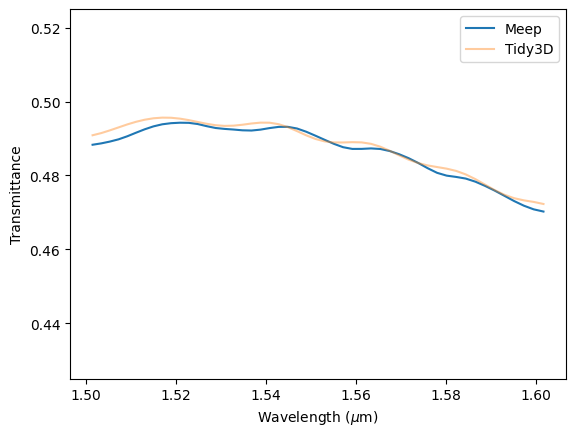

In [5]:
fig, ax = plt.subplots()

# loading Meep data
meep_data = np.loadtxt("misc/MeepMMI.txt")
freqs = meep_data.T[0]
flux = meep_data.T[1]

ax.plot(td.C_0 / freqs, flux, label="Meep")

ax.plot(
    td.C_0 / sim_data["Flux monitor"].flux.f,
    sim_data["Flux monitor"].flux,
    alpha=0.4,
    label="Tidy3D",
)
ax.legend()
ax.set_ylim(0.425, 0.525)

ax.set_ylabel("Transmittance")
ax.set_xlabel("Wavelength ($\mu$m)")

plt.show()

## Final Remarks

As we can see, the results deviate only due to numerical errors, likely caused by differences in meshing and subpixel averaging strategies.

Additionally, one could argue that the speed comparison may not be entirely fair, as the Tidy3D simulation was run on more powerful hardware. However, a direct comparison is not possible since Meep does not support GPU acceleration.

From a user’s perspective, both simulations were built and submitted on the same laptop. Therefore, Tidy3D offers the advantage of cloud computing, meaning that users do not need powerful hardware on hand to benefit from the speed advantage, nor do they need to dedicate a workstation for hours to a single simulation.